# Generate predictions over entire USA

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import random
from torch.utils.data import Dataset, DataLoader
import os
from models import LinToConv, SimplifiedMLP, LinToTransformer, MineralDataset, UNet, TransformerToConv, SpatialTransformer
from utils import (integral_loss, regular_loss, nonempty_loss, 
                   dice_coefficient_nonzero, absolute_difference_integral, save_overlay_predictions, create_gif)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load input datasets

In [2]:
use_minerals = True
use_geophys = False
use_raca_data = False

rocktype_file_path = './local_data/Rocktype.h5'
faults_file_path = './local_data/faults.h5'
geoage_file_path = './local_data/Geoage.h5'
elevations_file_path = './local_data/elevations.h5'
mineral_data_path = './local_data/100kmineralDataWithCoords_20000.h5'
raca_file_path = './local_data/raca_raw.pkl'

elements = ['Gold', 'Silver', 'Zinc', 'Lead', 'Copper', 'Nickel', 'Iron', 'Uranium', 'Tungsten', 'Manganese'] #+ \
           # ['Rock Type', 'Fault Presence', 'Fault Slip Rate', 'Max Age', 'Min Age', 'Elevation']

In [3]:
# Load datasets
def load_hdf5_data(file_path, dataset_name):
    print(f"Loading dataset {dataset_name} from {file_path}...")
    with h5py.File(file_path, 'r') as f:
        data = f[dataset_name][:]
        print(f"Loaded {dataset_name} with shape {data.shape}")
        return data

def normalize_layer(layer):
    min_val, max_val = np.min(layer), np.max(layer)
    normalized = (layer - min_val) / (max_val - min_val) if max_val != min_val else layer
    print(f"Normalized layer with min {min_val} and max {max_val}")
    return normalized

# Convert miles to degrees latitude and longitude
def miles_to_degrees_lat(miles):
    return miles / 69.0

def miles_to_degrees_lon(miles, latitude):
    return miles / (69.0 * np.cos(np.radians(latitude)))

In [4]:
if use_minerals:
    print("Loading mineral data...")
    mineral_data = load_hdf5_data(mineral_data_path, 'counts')
    mineral_data = np.nan_to_num(mineral_data, nan=-10)
    print("Mineral data shape:", mineral_data.shape)

    # Recast coord data as (batch, 2, 50, 50) = (batch, [lon layer, lat layer], lon, lat)
    coord_data = load_hdf5_data(mineral_data_path, 'coordinates') # [batch, [lon, lat]]

    # Get coordinate extent of box
    map_extent = np.zeros((coord_data.shape[0],2))
    map_extent[:,0] = miles_to_degrees_lon(50,coord_data[:,0])
    map_extent[:,1] = miles_to_degrees_lat(50)

    # Reshape coord_data and map_extent for broadcasting
    coord_data_x = coord_data[:, 1].reshape(coord_data.shape[0], 1, 1, 1)  # Shape: (nbatches, 1, 1, 1) for dimension 0
    coord_data_y = coord_data[:, 0].reshape(coord_data.shape[0], 1, 1, 1) 
    map_extent_x = map_extent[:, 0].reshape(coord_data.shape[0], 1, 1, 1)  # Shape: (nbatches, 1, 1, 1) for dimension 0
    map_extent_y = map_extent[:, 1].reshape(coord_data.shape[0], 1, 1, 1) 

    # Add lat/long data linearly to the coordinate data by interpolation
    rows = np.linspace(0, 1, 50).reshape(1, 1, 50, 1).repeat(50,axis=3)  # Shape: (1, 1, 50, 50)
    cols = np.linspace(0, 1, 50).reshape(1, 1, 1, 50).repeat(50,axis=2)  # Shape: (1, 1, 50, 50)
    
    # Interpolate along rows for dimension 1
    row_interp = coord_data_x.repeat(50,axis=2).repeat(50,axis=3) + rows * map_extent_x.repeat(50,axis=2).repeat(50,axis=3)

    # Interpolate along columns for dimension 0
    col_interp = coord_data_y.repeat(50,axis=2).repeat(50,axis=3) + cols * map_extent_y.repeat(50,axis=2).repeat(50,axis=3)

    # Combine into the final mapinfo_new tensor
    coord_data = np.concatenate(
        (row_interp, 
         col_interp), 
    axis=1)

    print("Coord data shape:", coord_data.shape)

else:
    mineral_data = None

if use_geophys:
    print("Loading geophysical data...")
    rock_type = normalize_layer(load_hdf5_data(rocktype_file_path, 'rock_type'))
    fault_presence = normalize_layer(load_hdf5_data(faults_file_path, 'fault_presence'))
    fault_slip_rate = normalize_layer(load_hdf5_data(faults_file_path, 'fault_slip_rate'))
    maximum_age = normalize_layer(load_hdf5_data(geoage_file_path, 'maximum_age'))
    minimum_age = normalize_layer(load_hdf5_data(geoage_file_path, 'minimum_age'))
    elevations = normalize_layer(load_hdf5_data(elevations_file_path, 'elevations'))
    geophysical_data = np.stack([rock_type, fault_presence, fault_slip_rate, maximum_age, minimum_age, elevations], axis=1)
    print("Geophysical data shape:", geophysical_data.shape)
else:
    geophysical_data = None

if use_raca_data:
    print("Loading RaCA data...")
    with open(raca_file_path, 'rb') as file:
        raca_data = pickle.load(file)
    print("RaCA data loaded successfully.")
else:
    raca_data = None

# Combine datasets dynamically
combined_data = []
if use_minerals:
    combined_data.append(mineral_data)
if use_geophys:
    combined_data.append(geophysical_data)
if use_minerals:
    combined_data.append(coord_data)

if combined_data:
    combined_data = np.concatenate(combined_data, axis=1)
    print("Combined minerals and geophysical data shape:", combined_data.shape)
else:
    combined_data = None
    print("No data selected for training.")

Loading mineral data...
Loading dataset counts from ./local_data/100kmineralDataWithCoords_20000.h5...
Loaded counts with shape (20000, 10, 50, 50)
Mineral data shape: (20000, 10, 50, 50)
Loading dataset coordinates from ./local_data/100kmineralDataWithCoords_20000.h5...
Loaded coordinates with shape (20000, 2)
Coord data shape: (20000, 2, 50, 50)
Combined minerals and geophysical data shape: (20000, 12, 50, 50)


In [5]:
dataset = MineralDataset(
        combined_data,
        input_minerals = [i for i in range(len(elements))],
        output_mineral=None,
        indices=np.arange(0, combined_data.shape[0]),
        train=False,
        sigma=1,
        unet=True,
        longlat=True,
)

dataloader = DataLoader(dataset, batch_size=100, shuffle=False, drop_last=False)

### Load model

In [6]:
model_path = "./local_models/model_0115_3SAVEFOREVAL_Run1_MineralsOnly_Seed42_minerals.pth"
model_state_dict = torch.load(model_path, map_location=torch.device('cpu'))

/var/folders/84/rsxv09b17_n57vhqltwy0p900000gn/T/ipykernel_58857/2893089869.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_path, map

In [7]:
model = UNet(10,10,"resnet152")
model.load_state_dict(model_state_dict["model_state_dict"])

<All keys matched successfully>

### Write utility function to evaluate model over dataset

In [25]:
import copy

def eval_map(model, data_loader, raca_data=None, raca_encoder=None):
    model.eval()
    if use_raca_data:
        assert raca_data is not None and raca_encoder is not None, "RaCA data and encoder must be provided for evaluation if --use_raca_data is enabled."
        raca_encoder.eval()

    predicted = None
    ground_truth = None

    iEvaluated = 0

    with torch.no_grad():
        for inputs, targets, idx, mask in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Save lat/long layers separately
            longlat = inputs[:,-2:,:-14,:-14]
            inputs = inputs[:,:-2,:,:]

            # Conditionally add RaCA embeddings if enabled
            if use_raca_data:
                raca_embeddings = getRACAembed(raca_data, idx, raca_encoder)
                inputs = torch.concatenate((inputs, raca_embeddings), dim=1)

            # Save ground truth data
            tground_truth = copy.deepcopy(targets)[:,:,:-14,:-14]
            tground_truth = torch.sum(tground_truth, dim=1)
            tground_truth = torch.stack((tground_truth, longlat[:,0,:,:], longlat[:,1,:,:]), dim=1)
            tground_truth = tground_truth.permute(0,2,3,1).reshape(-1,3)
            tground_truth = tground_truth[tground_truth[:,0] > 0]

            if ground_truth is None :
                ground_truth = tground_truth
            else :
                ground_truth = torch.concatenate((ground_truth,tground_truth), dim=0)

            # Forward pass
            outputs = model(inputs[:,:,:,:])

            # Apply mask to outputs
            outputs = outputs[:,:,:-14,:-14]
            targets = targets[:,:,:-14,:-14]
            mask = mask[:,:,:-14,:-14]

            outputs[mask != 1] = 0
            targets[mask == 1] = 0
            outputs = outputs + targets

            # Sum outputs along mineral axis to get number of predicted resources
            outputs = torch.sum(outputs,dim=1)
            mask = torch.sum(mask, dim=1)

            # Concatenate with lat, long to get object of size (batch,3,50,50)
            outputs = torch.stack((outputs, longlat[:,0,:,:], longlat[:,1,:,:]), dim=1)
            mask = torch.stack((mask, longlat[:,0,:,:], longlat[:,1,:,:]), dim=1)

            # Rearrange to a list of vectors of num, long, lat and add to list
            outputs = outputs.permute(0,2,3,1).reshape(-1,3)
            mask = mask.permute(0,2,3,1).reshape(-1,3)
            tpredicted = copy.deepcopy(outputs)[mask[:,0] > 0]
            if predicted is None :
                predicted = tpredicted
            else :
                predicted = torch.concatenate((predicted,tpredicted), dim=0)
            
            iEvaluated += tpredicted.shape[0]
            print("- Evaluated",iEvaluated)

    # Return filtered list of lat, long, num
    return predicted.numpy(), ground_truth.numpy()

### Create map

#### Load background raster, us border, and reproject to Albers Equal Area

In [26]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import mapping
from matplotlib.colors import LinearSegmentedColormap, Normalize
from pyproj import Transformer


src = rasterio.open("./local_data/geo/NE2_HR_LC_SR_W_DR.tif")
world = gpd.read_file("./local_data/geo/natural_earth_vector/10m_cultural/ne_10m_admin_0_countries_usa.shp")

usborder = world[world["NAME"] == "United States"]
usborder = usborder[~usborder["NAME"].isin(["Alaska","Hawaii"])]

contiguous_states = usborder.to_crs(src.crs)

geometries = [mapping(geom) for geom in contiguous_states.geometry]

clipped_raster, clipped_transform = mask(src, geometries, crop=True, nodata=245)

# Update the metadata to match the clipped raster
clipped_meta = src.meta.copy()
clipped_meta.update({
    "driver": "GTiff",
    "height": clipped_raster.shape[1],
    "width": clipped_raster.shape[2],
    "transform": clipped_transform,
    "nodata": 245
})


# Define a custom colormap: transparent to red
redcolors = [(1, 0, 0, 0), (1, 0, 0, 1)]  # RGBA: start with transparent red, end with opaque red
red_cmap = LinearSegmentedColormap.from_list('transparent_to_red', redcolors, N=256)

# Define a custom colormap: transparent to red
bluecolors = [(0, 0, 1, 0), (0, 0, 1, 1)]  # RGBA: start with transparent blue, end with opaque blue
blue_cmap = LinearSegmentedColormap.from_list('transparent_to_blue', bluecolors, N=256)


# Reproject US border to Albers Equal Area (EPSG: 5070)
desired_crs = "EPSG:5070"
usborder_proj = usborder.to_crs(desired_crs)

# Transformer for WGS84 (lat/lon) to Albers Equal Area
transformer = Transformer.from_crs("EPSG:4326", desired_crs, always_xy=True)

# Reproject the grid edges
lamin, lamax = 22, 51
lomin, lomax = -130, -55

# Reproject the raster
transform, width, height = calculate_default_transform(
    src.crs, desired_crs, src.width, src.height, *src.bounds
)

# 
clipped_raster_proj, clipped_transform_proj = mask(src, geometries, crop=True, nodata=245)

# Update the metadata to match the clipped raster
clipped_meta_proj = src.meta.copy()
clipped_meta_proj.update({
    "crs": desired_crs,
    "transform": transform,
    "width": width,
    "height": height
})

reprojected_raster = np.empty((clipped_raster_proj.shape[0], height, width), dtype=clipped_raster_proj.dtype)

reproject(
    clipped_raster_proj,
    reprojected_raster,
    src_transform=clipped_transform_proj,
    src_crs=src.crs,
    dst_transform=transform,
    dst_crs=desired_crs,
    resampling=Resampling.nearest
);

#### Generate data

In [27]:
import tqdm
from ipywidgets import FloatProgress

num_iterations = 3

gt_stack = None
p_stack = None

pRes_heatmap = None
pCount_heatmap = None
pCount_div = None

gtRes_heatmap = None
gtCount_heatmap = None
gtCount_div = None

px_bins,   py_bins = None, None
gtx_bins, gty_bins = None, None

pRes_xedges_proj,  pRes_yedges_proj = None, None
gtRes_xedges_proj, gtRes_yedges_proj = None, None

In [ ]:
# Generate data stack
for i in range(num_iterations) :
    print("Evaluating iteration",(i+1))
    if gt_stack is None :
        p_stack, gt_stack = eval_map(model,dataloader)
    else :
        p_stack, _ = eval_map(model,dataloader)
    
    print("Finished evaluating, converting p_stack...")

    # Get lists to histogram
    plons = p_stack[:,1]
    plats = p_stack[:,2]
    predResources = p_stack[:,0]
    predCounts = copy.deepcopy(predResources >= 0)

    print("Finished preparing p_stack...")

    gtlons = gt_stack[:,1]
    gtlats = gt_stack[:,2]
    gtResources = gt_stack[:,0]
    gtCounts = copy.deepcopy(gtResources >= 0)
    
    print("Finished preparing gt_stack...")

    # Get the projected long/lats for all data points
    px_proj, py_proj = transformer.transform(plons,  plats)
    gtx_proj, gty_proj = transformer.transform(gtlons, gtlats)

    # Generate initial heatmap
    if pRes_heatmap is None :

        # Define bins in the projected space
        # Adjust bin size dynamically (e.g., 10,000 meters = 10 km)
        bin_size = 10000  # 10 km per bin

        # Get bin information assuming up to +/- 50mi (80km) coverage of USA
        px_min, px_max = px_proj.min() - 80000, px_proj.max() + 80000
        py_min, py_max = py_proj.min() - 80000, py_proj.max() + 80000
        px_bins = np.arange(px_min, px_max + bin_size, bin_size)
        py_bins = np.arange(py_min, py_max + bin_size, bin_size)

        gtx_min, gtx_max = gtx_proj.min() - 80000, gtx_proj.max() + 80000
        gty_min, gty_max = gty_proj.min() - 80000, gty_proj.max() + 80000
        gtx_bins = np.arange(gtx_min, gtx_max + bin_size, bin_size)
        gty_bins = np.arange(gty_min, gty_max + bin_size, bin_size)

        # Create the predicted resource histogram in the projected space
        pRes_heatmap, pRes_xedges_proj, pRes_yedges_proj = np.histogram2d(
            px_proj, py_proj, bins=[px_bins, py_bins], weights=predResources
        )

        # Create the prediction count histogram in the projected space
        pCount_heatmap, _, _ = np.histogram2d(
            px_proj, py_proj, bins=[px_bins, py_bins], weights=predCounts
        )
        pCount_div = copy.deepcopy(pCount_heatmap)
        pCount_div[pCount_heatmap==0]=1

        # Create the heatmap in the projected space
        gtRes_heatmap, gtRes_xedges_proj, gtRes_yedges_proj = np.histogram2d(
            gtx_proj, gty_proj, bins=[gtx_bins, gty_bins], weights=gtResources
        )

        # Create the heatmap in the projected space
        gtCount_heatmap, _, _ = np.histogram2d(
            gtx_proj, gty_proj, bins=[gtx_bins, gty_bins], weights=gtCounts
        )
        gtCount_div = copy.deepcopy(gtCount_heatmap)
        gtCount_div[gtCount_heatmap==0]=1

    else :

        # Create the predicted resource histogram in the projected space
        tpRes_heatmap, _, _ = np.histogram2d(
            px_proj, py_proj, bins=[px_bins, py_bins], weights=predResources
        )

        # Create the prediction count histogram in the projected space
        tpCount_heatmap, _, _ = np.histogram2d(
            px_proj, py_proj, bins=[px_bins, py_bins], weights=predCounts
        )

        pRes_heatmap  += tpRes_heatmap
        pCount_heatmap  += tpCount_heatmap

        pCount_div = copy.deepcopy(pCount_heatmap)
        pCount_div[pCount_heatmap==0]=1
    
    # Define the extent of the heatmap in the projected space
    pextent_proj  = [pRes_xedges_proj.min(), pRes_xedges_proj.max(), pRes_yedges_proj.min(), pRes_yedges_proj.max()]
    gtextent_proj = [gtRes_xedges_proj.min(), gtRes_xedges_proj.max(), gtRes_yedges_proj.min(), gtRes_yedges_proj.max()]

    # Plot
    fig, ax = plt.subplots(figsize=(17, 4))
    ax.set_facecolor("#F0EAD6")

    usborder_proj.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
    # show(reprojected_raster, transform=transform, ax=ax, alpha=0.2)

    # Overlay heatmap
    im = ax.imshow((pRes_heatmap/pCount_div).T, origin='lower', extent=pextent_proj, cmap=red_cmap, alpha=0.5)
    im = ax.imshow((gtRes_heatmap/gtCount_div).T, origin='lower', extent=gtextent_proj, cmap=blue_cmap, alpha=0.25)

    # Set viewport to the entire US
    x_min, x_max = usborder_proj.total_bounds[0] + 4500000, usborder_proj.total_bounds[2] + 200000  # US border X (easting)
    y_min, y_max = usborder_proj.total_bounds[1] + 800000, usborder_proj.total_bounds[3] - 3000000  # US border Y (northing)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Add colorbar
    #cbar = plt.colorbar(im, ax=ax, label='Predicted Resource Density')
    ax.axis('off')

    # Show
    plt.show()
    


Evaluating iteration 1
- Evaluated 141051
- Evaluated 303244
- Evaluated 465204
- Evaluated 617664
- Evaluated 786424
- Evaluated 929405


#### Plot map

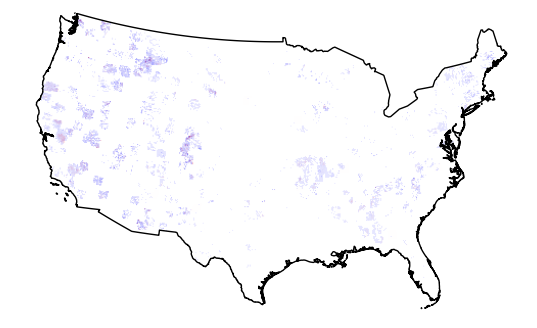

In [52]:
import geopandas as gpd

# Define the extent of the heatmap in the projected space
pextent_proj  = [pRes_xedges_proj.min(), pRes_xedges_proj.max(), pRes_yedges_proj.min(), pRes_yedges_proj.max()]
gtextent_proj = [gtRes_xedges_proj.min(), gtRes_xedges_proj.max(), gtRes_yedges_proj.min(), gtRes_yedges_proj.max()]

# Plot
fig, ax = plt.subplots(figsize=(17, 4))
ax.set_facecolor("#F0EAD6")

usborder_proj.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
# show(reprojected_raster, transform=transform, ax=ax, alpha=0.2)

# Overlay heatmap
im = ax.imshow((pRes_heatmap/pCount_div).T, origin='lower', extent=pextent_proj, cmap=red_cmap, alpha=0.5)
im = ax.imshow((gtRes_heatmap/gtCount_div).T, origin='lower', extent=gtextent_proj, cmap=blue_cmap, alpha=0.5)

# Set viewport to the entire US
x_min, x_max = usborder_proj.total_bounds[0] + 4500000, usborder_proj.total_bounds[2] + 200000  # US border X (easting)
y_min, y_max = usborder_proj.total_bounds[1] + 800000, usborder_proj.total_bounds[3] - 3000000  # US border Y (northing)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)



# Add colorbar
#cbar = plt.colorbar(im, ax=ax, label='Predicted Resource Density')
ax.axis('off')

# Show
plt.show()

#### Plot map without projection

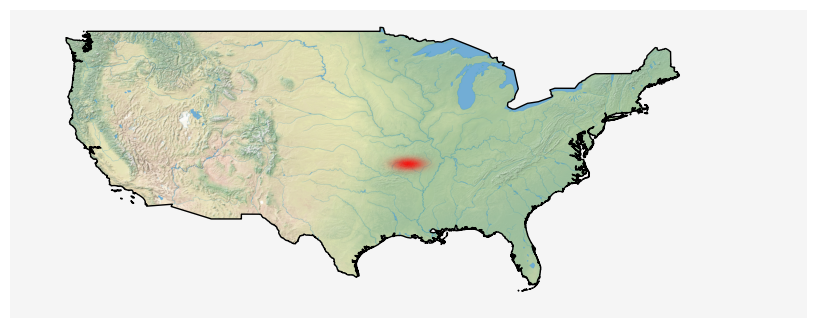

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Create a grid
# lat_bins = np.linspace(lamin, lamax, 1000)
# lon_bins = np.linspace(lomin, lomax, 1000)
# heatmap, xedges, yedges = np.histogram2d(lats, lons, bins=[lat_bins, lon_bins], weights=values)

# Plot
fig, ax = plt.subplots(figsize=(20, 4))
ax.set_facecolor("#F0EAD6")

usborder.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
show(clipped_raster, transform=clipped_transform, ax=ax)

# Overlay heatmap
im = ax.imshow(heatmap.T, origin='lower', extent=[lomin, lomax, lamin, lamax], cmap = red_cmap, alpha=1.0)

# Add colorbar
#cbar = plt.colorbar(im, ax=ax, label='Predicted Resource Density')
ax.axis('off')

# Show
plt.show()